Load input. Log(1+TPM) of protein-coding genes from depmap was downloaded from [here](https://depmap.org/portal/data_page/?tab=allData&releasename=DepMap%20Public%2024Q4&filename=OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv):

Metastatic potential was obtained from [Metmap 500](https://depmap.org/metmap/data/index.html).

In [20]:
import os
from tqdm import trange

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats


import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
seed = 42
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'

In [22]:
mp = pd.read_excel(os.path.join(data_path, 'raw', 'Supplementary Table 04 MetMap 500 met potential.xlsx'), 
                   sheet_name = 'metp500.all5', index_col = 0)

md = pd.read_csv(os.path.join(data_path, 'raw', 'Model.csv'), index_col = 0)

expr = pd.read_csv(os.path.join(data_path, 'raw', 'OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv'), 
                          index_col = 0)


Map the sample IDs to match between X (expression) and y (metastatic potential)

In [23]:
n_samples_mp_og = mp.shape[0]
sample_map = dict(zip(md.CCLEName, md.index))
mp['sample_id'] = mp.index.map(sample_map)
mp = mp[mp.sample_id.notna()]
n_samples_mp = mp.shape[0]
mp.set_index(mp.sample_id, drop = True, inplace = True)

print('{} of {} samples in the metastatic potential were retained after sample ID mapping'.format(n_samples_mp, n_samples_mp_og))


484 of 488 samples in the metastatic potential were retained after sample ID mapping


Retain overlapping samples between the expression nad metastatic potential dataset:

In [24]:
intersect_samples = sorted(set(expr.index).intersection(mp.index))
n_samples_expr_og = expr.shape[0]
print('{} samples overlap betwee the {} in the expression dataset and the {} in the metastatic potential dataset'.format(len(intersect_samples), n_samples_expr_og, n_samples_mp))

mp = mp.loc[intersect_samples, :]
expr = expr.loc[intersect_samples, :]


481 samples overlap betwee the 1673 in the expression dataset and the 484 in the metastatic potential dataset


Look at the data distributions:

In [25]:
stats_novst = pd.DataFrame({'mean': expr.mean(axis = 0), 'variance': expr.var(axis = 0)})
# stats_novst.reset_index(drop=True, inplace = True)

''

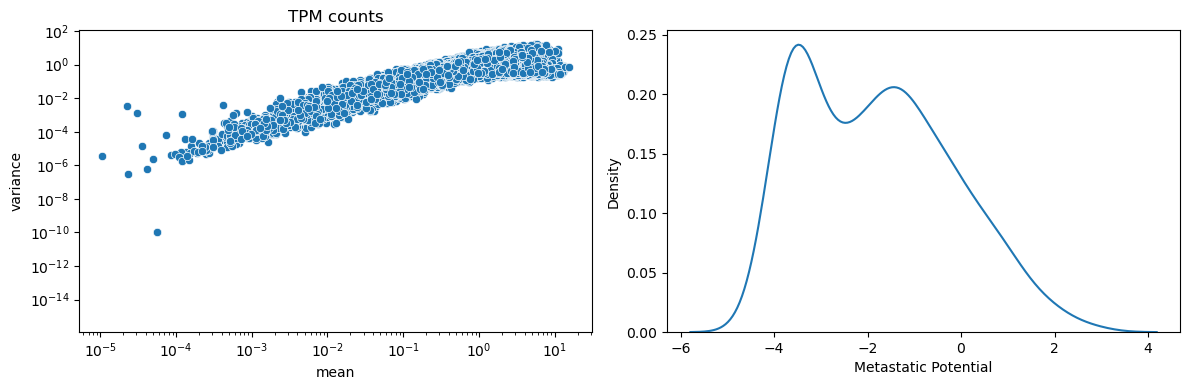

In [26]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
ax = ax.flatten()

# subplot 1
i = 0
sns.scatterplot(data = stats_novst, x = 'mean', y = 'variance', ax = ax[i])
ax[i].set_xscale('log')
ax[i].set_yscale('log')
ax[i].set_title('TPM counts')

# subplot 2
# i += 1
# sns.scatterplot(data = stats, x = 'mean', y = 'variance', ax = ax[i])
# ax[i].set_xscale('symlog')
# ax[i].set_yscale('log')
# ax[i].set_title('VST counts')
# ax[i].yaxis.set_major_locator(ticker.FixedLocator([0.01, 0.1, 1, 10]))
# ax[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

# # subplot 3
# i+=1
# sns.kdeplot(nexpr.sum().tolist(), ax = ax[i])
# ax[i].set_xlabel('Sample-wise TPM Count Sum')
# # ax[i].set_xscale('log')

# subplot 4
i+=1
sns.kdeplot(data=mp, x='mean', ax = ax[i])
ax[i].set_xlabel('Metastatic Potential')

fig.tight_layout()
;

Filter out low expression genes (mean <= 0.01) -- note, largest abs(mean) of genes with negative means (due to batch correction) is 7.2e-3.

In [27]:
min_mean_val = 0.1
low_expr_mask = (stats_novst['mean'] <= min_mean_val)
low_expr_features = stats_novst[low_expr_mask].index.tolist()
print('{} features have mean expression below {:.2f} and will be excluded from the pipeline'.format(len(low_expr_features), min_mean_val))

expr = expr.loc[:, ~low_expr_mask].copy()
stats_novst = pd.DataFrame({'mean': expr.mean(axis = 0), 'variance': expr.var(axis = 0)})


2767 features have mean expression below 0.10 and will be excluded from the pipeline


In [28]:
# g = sns.histplot(stats_novst['mean'])
# g.set_xlabel('Mean Per-Feature Expression')

Let's take a look at the associations between our model pipeline feature selection step (VST) and these distributions:

In [29]:
# remove negative values 
shift = -expr.min().min() + 1e-8
expr_shifted = expr + shift

# get log of mean and variance
m_log = np.log(expr_shifted.mean(axis = 0))
v_log = np.log(expr_shifted.var(axis = 0, ddof = 1))

# fit lowess curve and get absolute residuals
y_fit = lowess(v_log, m_log, frac=0.3, return_sorted=False) 
resid = (v_log - y_fit).sort_values(ascending = False) # signed residuals -- high positive means more variance than expected

resid = pd.DataFrame(resid, columns = ['residual'])

# resid['mean'] = m_log
# resid['var'] = v_log
resid = pd.concat([resid,
           stats_novst.loc[resid.index, :]], axis = 1)

sr = stats.spearmanr(resid.residual, resid['mean']).statistic
print('The Spearman between expression mean and feature selection rank is: {:.3f}'.format(sr))
sr = stats.spearmanr(resid.residual, resid['variance']).statistic
print('The Spearman between expression variance and feature selection rank is: {:.3f}'.format(sr))

The Spearman between expression mean and feature selection rank is: 0.009
The Spearman between expression variance and feature selection rank is: 0.848


''

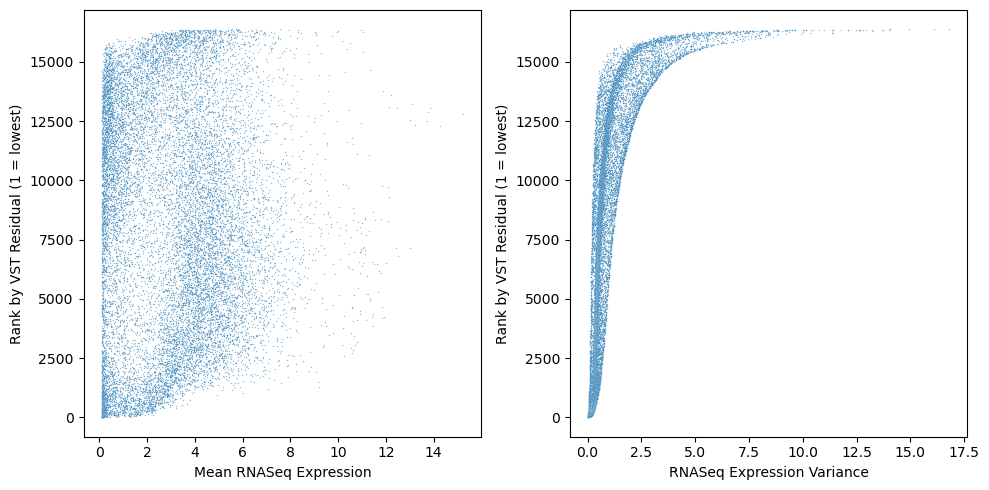

In [30]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

resid['feature_selection_rank'] = resid['residual'].rank(ascending=True)  # 1 = lowest CV

i = 0
sns.scatterplot(data=resid, x='mean', y='feature_selection_rank', alpha=0.5, s = 1, ax = ax[i])
ax[i].set_xlabel("Mean RNASeq Expression")
ax[i].set_ylabel("Rank by VST Residual (1 = lowest)")

i = 1
sns.scatterplot(data=resid, x='variance', y='feature_selection_rank', alpha=0.5, s = 1, ax = ax[i])
ax[i].set_xlabel("RNASeq Expression Variance")
ax[i].set_ylabel("Rank by VST Residual (1 = lowest)")

fig.tight_layout()
;

In [31]:
mp.to_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'))
expr.to_csv(os.path.join(data_path, 'processed', 'expr.csv'))